<h1 style='text-align: center;'> MTMW14 Project 2: Simple Ocean Gyre Model </h1>
<h2 style='text-align: center;'> Student ID: 31827379 </h2>
    
### 1. Introduction

In this project, we implement a simple dynamical model of a wind-driven circulation in a closed ocean basin, based on the work of Stommel (1948). The model can be used to demonstrate western boundary intensification, characterised by the clustering of streamlines at western continental boundaries. This is a prevalent feature in oceanic wind-driven circulations, exemplified by phenomena such as the Gulf stream or the Kuroshio current. 

Considering a rectangular oceanic basin of length $L$ and with a single layer of fluid, we can represent the system with the shallow water equations linearised about a resting state. These are given in Equations 1 and 2.

\begin{align}
&\frac{\partial \eta}{\partial t} + H \nabla \cdot \vec{V} = 0 \\
&\frac{\partial \vec{V}}{\partial t} + (f_0 + \beta y) \hat{k} \times \vec{V} = -g \nabla \eta - \gamma \vec{V} + \frac{\vec{\tau}}{\rho H}
\end{align}

Equations 1 and 2 represent conservation of mass and momentum, respectively, where the prognostic variables are the height perturbation ($\eta$) and the depth integrated horizontal velocity ($\vec{V}$). We have neglected inertial terms since these are assumed to be small, and have further assumed uniform density ($\rho$) and a constant resting height ($H$). Planetary rotation effects are incorporated through the beta plane approximation ($f=f_0 + \beta y$), and the model additionally features a damping term ($\gamma \vec{V}$) to depict momentum dissipation through friction at the ocean floor. In a mid-latitude beta plane, the surface wind stress ($\vec{\tau}$) represents the easterly trade winds over the equatorial half of the basin, and the mid-latitude westerlies over the poleward half. Assuming no meridional wind stress, we model this as a sinusoidal function varying with latitude, as shown in Equation 3.

\begin{align}
\vec{\tau} =
\begin{pmatrix}
\tau_x \\
\tau_y \\
\end{pmatrix}
= \tau_0
\begin{pmatrix}
- \cos\left(\frac{\pi y}{L}\right) \\
0 \\
\end{pmatrix}
\end{align}

In this report we will experiment with different numerical approaches to solving the system of equations outlined in Equations 1 and 2. In Sections 2 we make decisions regarding the model setup, and in Section 3 onwards we will present and discuss the results.

In [1]:
import assignment2 as assign2 # Takes a little while since some data is run and stored globally.

### 2. Task A and B: Model setup

#### 2.1 Timestep calculation

To ensure stability of the numerical solution, we use the CFL criterion (Equation 4) to provide an upper bound on the step size ($\Delta t$). This criterion dictates that the distance travelled by the flow in one time step must not exceed the grid spacing, and we are thus limited by two variables: the flow speed ($V_s$) and the grid spacing ($\Delta x$). 

To find the limiting flow speed, we first consider the different types of waves that our model can support. While compression waves, like sound waves, typically travel on the shortest timescales, our assumption of an incompressible fluid means that they cannot exist in our model. Thus, the next fastest waves we need to consider are gravity or inertia-gravity waves. Figure 1 illustrates an example of a gravity wave for the case of no planetary rotation, wind stress or drag terms. To spawn the waves, the height perturbation field is initialised with a 2D Gaussian mountain.

In [2]:
assign2.wavesDemo.displayGravityWave()

,


Figure 1: Gravity waves spawned by initialising the height perturbation field with a 2D Gaussian mountain. Left-hand figure shows the time evolution of the height perturbation, and the right-hand figure shows the velocity field for the same time frame. Reflective boundary conditions are applied for an Arakawa-C grid, and the forward-backward numerical scheme is used with a timestep of $35$s. The domain is a square basin with $L=1000$km, grid spacing $\Delta x=5$km, and resting height $H=1000$m. Make sure to see the notebook version if you're reading the pdf - these are animated!

Kelvin waves, which can be thought of as equatorially trapped gravity waves, are also supported by the model, and travel at the same phase speeds as their unbounded counterparts. Figure 2 shows an example of an equatorially trapped Kelvin wave propagating eastward. Both Kelvin and inertia-gravity waves act to redistribute mass such that pressure gradients are flattened. This means that if a simulation is run until some steady state is reached, these waves will eventually dissipate once an ideal arrangement of mass has been obtained. 

In [3]:
assign2.wavesDemo.displayKelvinWave()

,


Figure 2: Kelvin waves spawned by initialising the height perturbation field with a 2D Gaussian mountain. Left-hand figure shows the time evolution of the height perturbation, and the right-hand figure shows the velocity field. An Arakawa-C grid is used with periodic boundary conditions in the x-direction and reflective boundary conditions in the y-direction. The forward-backward numerical scheme is used with a timestep of $35$s. An equatorial beta plane is included with $\beta=10^{-8} m^{-1}s^{-1}$ to increase the effects of rotation, and the effects of wind-stress or drag are neglected. The domain is a square basin with $L=1000$km centred at $y=0$m. Grid spacing is $\Delta x=5$km and resting height is $H=1000$m.

Rossby waves are also supported by the model for $\beta \neq 0$, since this allows for a background potential vorticity gradient to exist. They can be initiated by geostrophic initial velocities and vertical shear in the height perturbation field, or from flow over mountains, and will eventually dissipate over time. These are typically much slower than inertia-gravity waves, so will not be considered further in our calculation of a suitable timestep. The limiting flow speed that we need to consider is therefore the phase speed of gravity waves, given by $c=\sqrt{gH}$. For a height of $H=1000$m and gravitational acceleration of $g=10ms^{-2}$, the phase speed is calculated as $c=100$m/s.

The grid spacing is the second limiting variable for the CFL criterion. This must be small enough to capture features of interest in the flow, but not too small that we incur excessive computational costs. The feature that we are interested in modelling is the western boundary current in an ocean gyre, and in Stommel (1948) this region is shown to have a width of less than 100km. We therefore choose our grid spacing as $\Delta x=\Delta y=d=25$km, with an absolute upper bound of $d=50$km should we require a coarser mesh. We can now calculate our timestep using the CFL criterion in Equation 4, which modifies the grid spacing for the worst-case scenario of 45&deg; flow over a 2D grid.


\begin{align}
\Delta t \leq \frac{d}{\sqrt{2}V_s}
\end{align}

For a flow speed of $V_s=100$m/s and a grid spacing $d=25$km, the CFL criterion allows us to use a timstep of $\Delta t=176$s. 

#### 2.2 Choice of grid

Stability of our scheme and the quality of solutions is also dependent on our choice of grid. This can be chosen by calculating the ratio of the Rossby radius of deformation (Equation 5) to the grid spacing.

\begin{align}
R_d = \frac{\sqrt{gH}}{f_0}
\end{align}

For a mid-latitude beta plane we have $f_0=10^{-4}s^{-1}$, such that $R_d=10^{6}$m. The ratio of Rossby radius of deformation to the grid spacing is therefore $R_d/d=20$, putting us in the fine grid regime. For this regime we choose to implement the Arakawa-C grid (Figure 3), since this gives the most accurate dispersion relationship for inertia-gravity waves. We implement reflective boundary conditions, such that there is no normal flow and zero $\eta$ flux across the boundaries. In practice, we do not update the boundary velocities since these are always zero, and consequently we do not need to incorporate the flux boundary condition for $\eta$ into the model. 

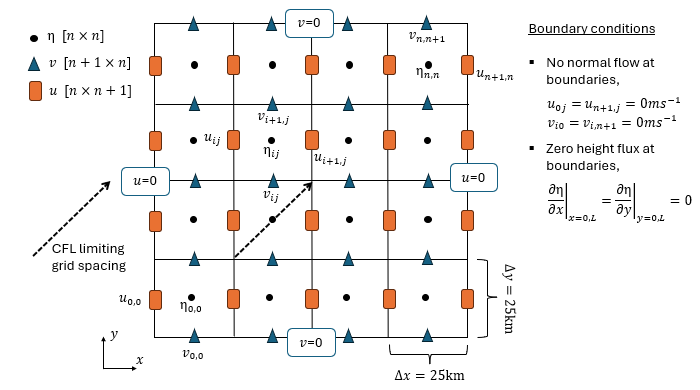

In [4]:
assign2.displayArakawaGrid()

Figure 3: A schematic illustrating the Arakawa-C grid, showing where each variable is stored on the grid. The dashed arrow shows the worst-case flow scenario that must be considered for the CFL criterion. The chosen grid spacing is $d=25$km and we have chosen reflective boundary conditions.

In what follows, we use a forward-backward time scheme (Matsuno 1965) unless stated otherwise. We assume a mid-latitude beta plane such that $f_0=10^{-4}s^{-1}$ and $\beta=10^{-11}m^{-1}s^{-1}$, and our grid domain is $[0 \times L]\times[0 \times L]$ where $L=1000$km. Our drag coefficient is $\gamma=10^{-6}s^{-1}$ and the wind-stress amplitude is $\tau_0=0.2Nm^{-2}$. The fluid density is $\rho=1000kgm^{-3}$, the gravitational acceleration is $g=10ms^{-2}$ and the resting height is $H=1000$m.

### 3. Task C: Steady state analytical solution of the linear model

To provide a benchmark test for our numerical experiments, we consider the analytical solution for steady state derived in Mushgrave (1985). The solution depends on an unknown constant of integration $\eta_0$, which can be taken to be $\eta_0=0$ at the very start of the simulation as the gyre is starting to form. Figure 4 shows contour plots of the velocities and the height perturbation for this solution.

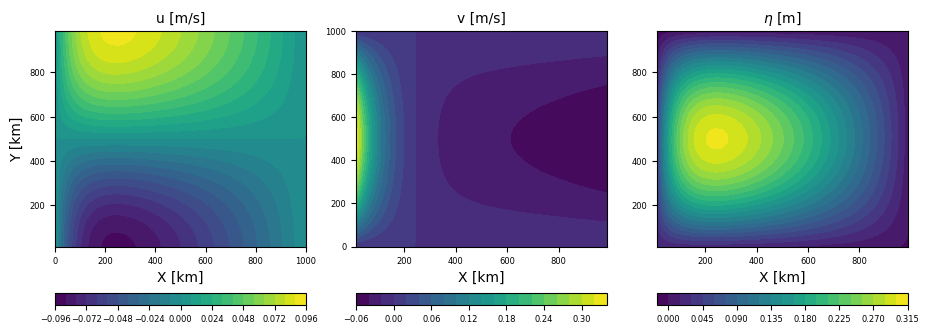

In [5]:
assign2.runTaskC()

Figure 4: Analytical solutions for the gyre at steady state for $\eta_0=0$.

In the exact solution $\eta_{st}(0, L/2)=\eta_0$, such that the final value of $\eta_{st}(0, L/2)$ from the model can be used as a good estimate of $\eta_0$. In what follows, model comparisons to the analytical solution will be done by taking $\eta_0$ from the model's steady state.

### 4. Task D: Numerical solution of the forward-backward time scheme

In this section we consider the numerical solutions of the forward-backward scheme.

#### 4.1 Results after 1 day 

The model is initially run for one day and the resulting numerical solutions of the forward-backward scheme are shown in Figure 5.

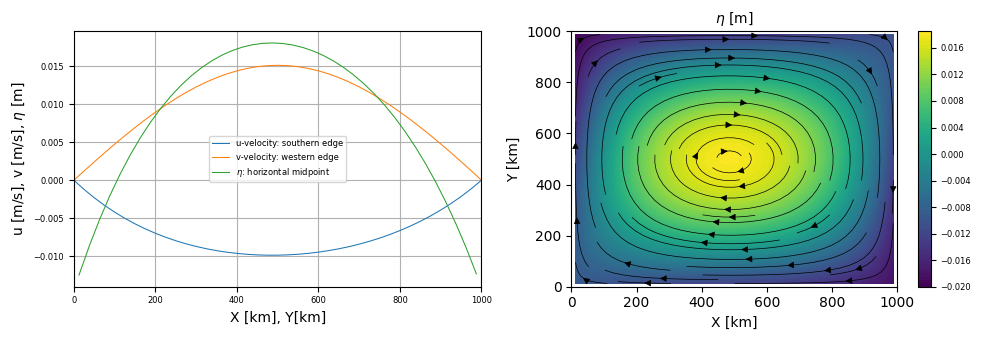

In [6]:
assign2.runTaskD1()

Figure 5: Numerical solutions from the forward-backward scheme after one day. The right-hand plot shows the height perturbation contour plot overlayed with the velocity streamlines. The left-hand plot shows different sections of the gyre: the u velocity along the southern edge, the v velocity along the western boundary, and the height perturbation through the midpoint of the gyre.

The results of Figure 5 confirm that the scheme is stable, and we can observe that the gyre is starting to form. The streamlines depict a clockwise rotation (anticyclonic in the northern hemisphere), and the height perturbation field is symmetric since the western boundary current has not yet formed. Notably, the maximum height perturbation occurs at the centre of the domain, with the vertical maximum position coinciding with the change in wind stress direction. This behaviour can be explained by considering that the wind stress exerts a clockwise torque on the flow. Ekman transport thus induces inward flow towards the centre of the gyre, resulting in a positive height perturbation at the interior, peaking at the centre, and negative perturbations beyond the boundaries. In the ocean, this would result in downwelling at the centre, but in our single-layer model we cannot observe this.

Along the western boundary, the meridional velocity moves poleward and has its maximum at the centre, again coinciding with the change in wind stress direction. Along the southern boundary, the zonal flow is westward and has its maximum coinciding with the horizontal maximum of the height perturbation. The location of these velocity maximum positions is perhaps due to the existence of the largest height perturbation gradients (pressure gradients) perpendicular to their respective flow directions.

#### 4.2 Results at steady state 

The model is now run until steady state. In Section 5 it will be shown that this occurs after approximately 40 days, and the results are shown in Figure 6. We can see that there is generally good agreement between the numerical and analytical solutions.

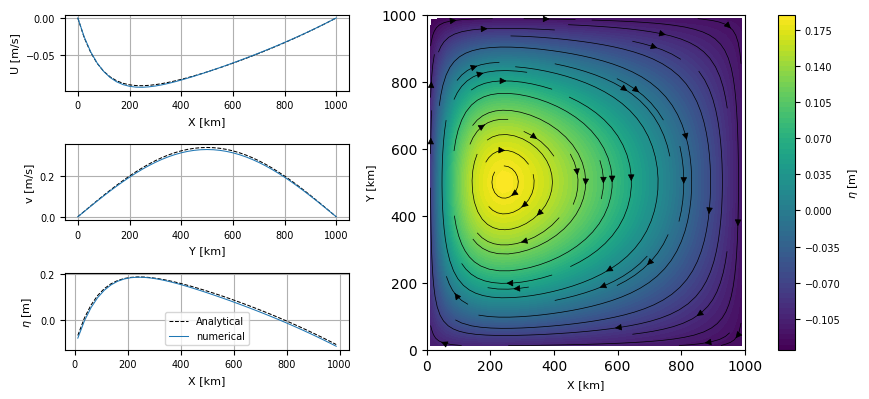

In [7]:
assign2.runTaskD2()

Figure 6: Numerical solutions of the forward-backward scheme after 40 days. The right-hand plot shows the height perturbation contour plot overlayed with the velocity streamlines. The left-hand plots show different sections of the gyre plotted against the analytical steady state solution from Section 3: the top plot shows the u velocity at the southern boundary, the middle plot shows the v velocity at the western boundary and the bottom plot shows $\eta$ along the gyre midsection.

Figure 6 shows significant zonal asymmetry in the gyre compared to Figure 5. The peak in surface elevation has shifted westward, and the velocities along the southern and western boundaries have increased. The maximum position of the westward zonal velocity along the southern edge has also shifted in alignment with the surface elevation peak. Notably, a pronounced crowding of streamlines is evident along the western boundary, coinciding with maximum gradients in surface elevation. These observations indicate the formation of a western boundary current.

The steady state distribution can be understood by considering the absolute vorticity budget of the gyre. Away from the boundaries, the gyre is approximately in Sverdrup balance, where the planetary advection of vorticity is balanced by the curl of the wind stress (a vorticity source). Since the wind stress exerts a clockwise torque on the gyre (negative curl), equatorward transport occurs within the gyre, as illustrated in Figure 6. To conserve mass, there must be a poleward return flow that is equal and opposite to the Sverdrup transport across every latitude. Figure 6 shows this occurring at the western boundary, where the drag term acts as a vorticity sink and balances the advection of vorticity. In Figure 5, the symmetric solution indicates that these balances have not yet been achieved. As water piles up at the center, the interior flow must become increasingly equatorward over time in order to conserve potential vorticity. This process causes the peak to shift westward until a steady state is reached, as is observed in Figure 6.

#### 4.3 Differences between steady state and the analytical model

The differences between the numerical and analytical solutions are now compared. To do this, the difference fields are calculated as in Equations 6 to 8.

\begin{align}
u' = u - u_{st} \\
v' = v - v_{st} \\
\eta' = \eta - \eta_{st}
\end{align}

Here, the subscript $st$ denotes the analytical solution. The energy is calculated from these differences fields (Equation 9) and serves as an error metric for the numerical solution. The calculated energy difference was $3.21\times10^{12}$J, with Figure 7 displaying the contours of energy differences.

Energy difference is 3.21e+12 J


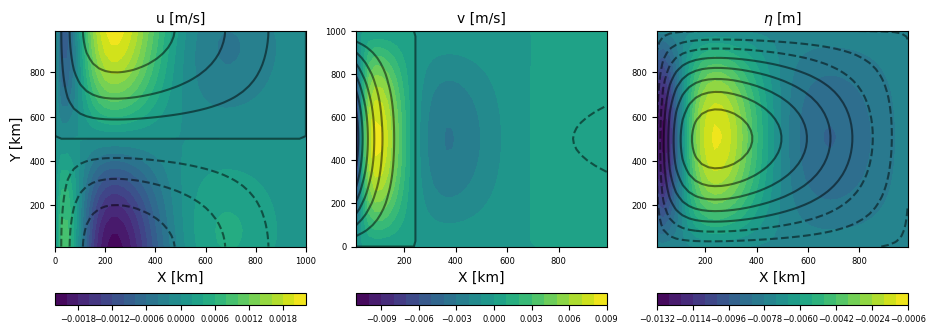

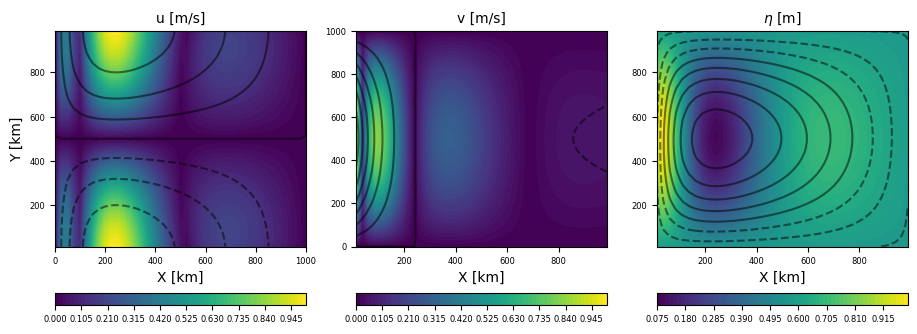

In [8]:
assign2.runTaskD3()

Figure 7: Contours of energy differences. Upper plot shows the energy difference contours as defined in Equations 6 to 8. Lower plot shows the absolute normalised energy differences, where the absolute energy differences are scaled between 0 and 1. Black contour lines show the numerical solution.

The top row of Figure 7 presents energy differences computed from the difference fields in Equations 6 to 8, indicating relatively minor disparities. While velocities tend to be overestimated at their extreme values, there is an underestimation of the meridional velocity along the western boundary. Similarly, the numerical solution for surface elevation appears to overestimate the peak and underestimate the trough at the western boundary.

Normalised absolute error differences are depicted in the lower row, revealing larger disparities in regions with significant gradients, where the numerical scheme may not be as accurate. Some errors accumulate away from these gradients, likely due to interconnected errors between solutions. Some bands of low energy difference are attributed to error cancellations, since they occur in between regions of overestimations and underestimations. For example, the vertical bands of low error straddling the u velocity peaks.

### 6. Task E for Energy

In previous sections we have used the energy difference between the analytical and numerical solutions as an error metric. Here, we define the energy (Equation 9) as the total energy of the perturbation from a resting ocean.

\begin{align}
E(u, v, \eta) = \int\limits_{0}^{L}\int\limits_{0}^{L} \left(\frac{1}{2}\rho\left(H(u^2 + v^2) + g\eta^2\right)\right) \, dx \, dy
\end{align}

We run the model for different grid resolutions, ranging from a coarse grid of $200$km to a fine grid of $5$km. With each new grid spacing, we adjust the timestep using Equation 4. Subsequently, we compute the time evolution of energy for each grid spacing, and compare the resulting energy difference with the analytical solution at steady state. The outcomes are depicted in Figure 8.

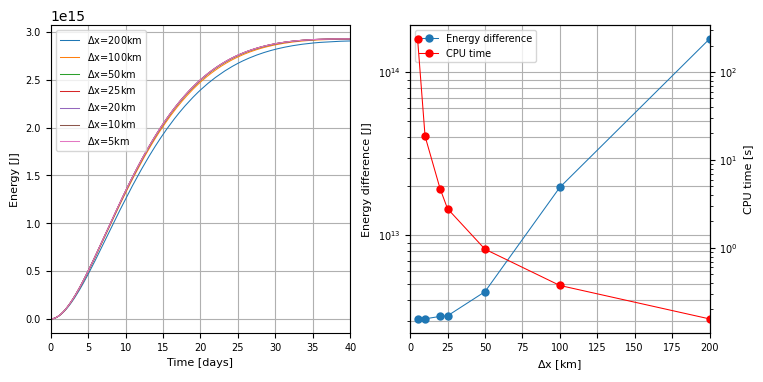

In [9]:
assign2.runTaskE() # Takes about 2.5 minutes on my laptop (running a few different resolutions).

Figure 8: Left-hand figure shows the time series of the energy for different grid resolutions. Right-hand figure shows the energy difference between the numerical and analytical solutions, and CPU time for the different grid spacings. The energy difference and CPU time axes are log scale to better illustrate the trends at higher resolutions.

The time evolution of energy in Figure 8 shows the higher resolution models converging to a steady state at approximately 40 days. The model with $\Delta x=200$km appears to reach steady state later, likely because the grid spacing is too large to represent the western boundary current. The right-hand figure demonstrates that as model resolution increases, the energy difference diminishes, suggesting a more accurate representation of the ocean gyre. Nonetheless, higher resolution models incur greater computational cost, as evidenced by longer model runtimes (CPU time). This is attributable to the increased number of grid points, as well as the greater number of timesteps necessitated by the CFL criteria.

In Section 2 we chose a grid spacing of $\Delta x=25$kms. Figure 8 (right) shows that this resolution strikes an acceptable balance between accuracy, as measured by the energy difference, and computational cost. Alternatively, a grid spacing of $\Delta x=50$km could have been considered for slightly faster runs at the expense of some accuracy. Resolutions lower than these result in a notable increase in the energy difference, while resolutions higher than these entail excessively long computation times.

### 7. Task F: The semi-Lagrangian method and the non-linear model

We now implement the semi-Lagrangian method (Appendix A) to solve the full non-linear shallow water equations. For this scheme, we replace the local rate of change in Equation 2 with the material derivative, thereby incorporating inertial terms into our model. It should be noted that this is a very naive implementation of the semi-Lagrangian scheme, and we were not able to use a timestep greater than the one dictated by the CFL criterion.

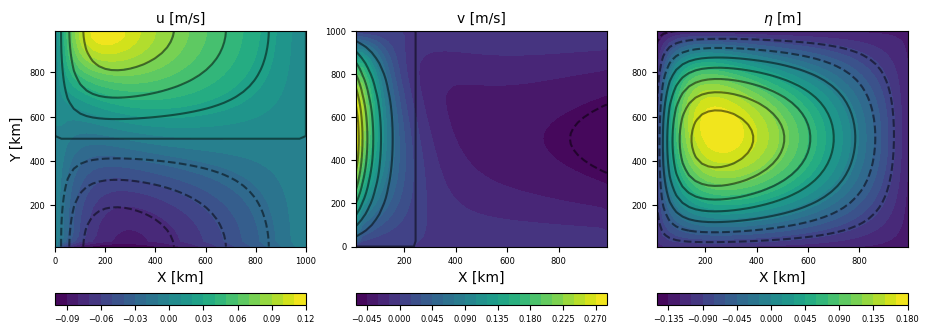

In [10]:
assign2.runTaskF1()

Figure 9: The contour plots showing the non-linear numerical solution for the semi-lagrangian time scheme after 40 days. The shading is the numerical solution, and the black contour plots is the analytical solution for the linear model.

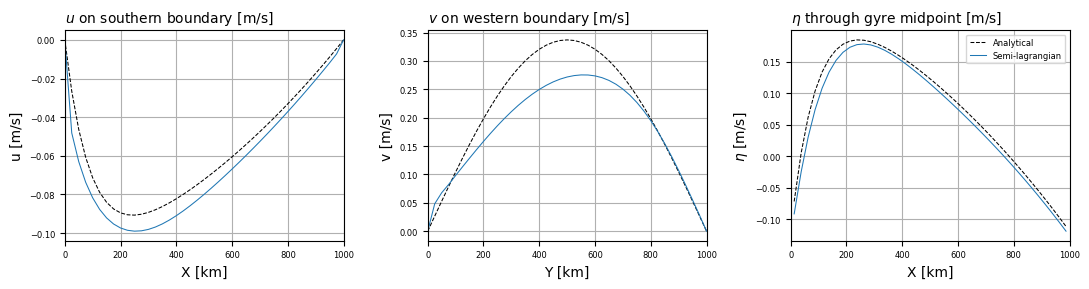

In [11]:
assign2.runTaskF2()

Figure 10: The semi-lagrangian solution compared with the analytical steady state solution at different sections of the gyre.

Figures 9 and 10 compare the non-linear semi-Lagrangian model with the linear analytical solution. In Figure 9, contour plots reveal significant differences between the two. The semi-Lagrangian model overshoots in the northern sector of the western boundary current, evident from the displacement of the surface elevation peak towards the northwest, accompanied by skewed velocity fields in the same direction. In Figure 10, the surface elevation peak in the gyre's midsection is notably smaller than in the analytical solution, likely due to its shift towards the northwest. Additionally, the vertical velocity within the western boundary current is weaker, with its maximum shifted northward, while the horizontal velocity along the southern boundary is overestimated.

This behaviour is similar to what is observed in Veronis (1966), where non-linearity effects are integrated into Stommel's model. Veronis demonstrates that increasing the linear drag coefficient renders inertial terms negligible, reverting to linear solutions. Conversely, reducing the drag coefficient leads to overshooting in the northern gyre and eventually triggers a jet formation in the northern domain boundary. Thus, the overshooting behavior in the semi-Lagrangian scheme is likely attributed to model non-linearity. It is possible that we could recover the linear solutions by increasing the effects of friction.

Energy difference is 7.69e+13 J


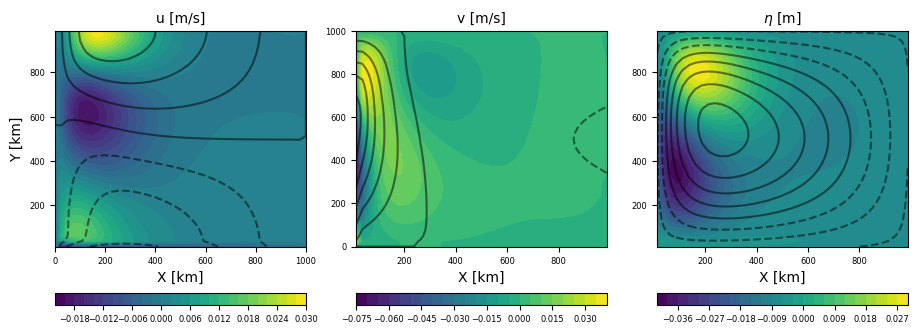

In [12]:
assign2.runTaskF3()

Figure 11: Contours of field differences, as defined in Equations 6 to 8. Black contour lines show semi-Lagrangian numerical solution of the model.

The energy difference between the semi-Lagrangian and analytical linear solutions is $7.69\times10^{13}$J, exceeding what was calculated in Section 4.3, largely due to the non-linearity of the current model. Comparing the field differences of Figure 11 with those of Figure 7, we observe significantly larger differences, with errors appearing rotated and skewed towards the northwestern corner, mirroring the solution pattern. The u velocity field has more pronounced differences, and interestingly includes a strip of negative error at the southern boundary. It is possible that I have made a mistake in how I have dealt with departure points beyond the boundaries within the implemented scheme, possibly resulting in error propagation throughout the flow field. Or the semi-Lagrangian scheme is just inaccurate.

### 8. Task G: Comparison of time schemes

For this section, we present the linear Runge-Kutte 4 and semi-implicit schemes, and compare these solutions with those we have obtained. 

#### 8.1 Comparing numerical solutions

The Runge-Kutte-4 scheme is implemented as described in the notes, and the semi-implicit scheme is described in Appendix A. They are each run for 40 days until steady state, using the CFL benchmark timstep of $\Delta t=176$s in order to compare with the previously considered schemes.

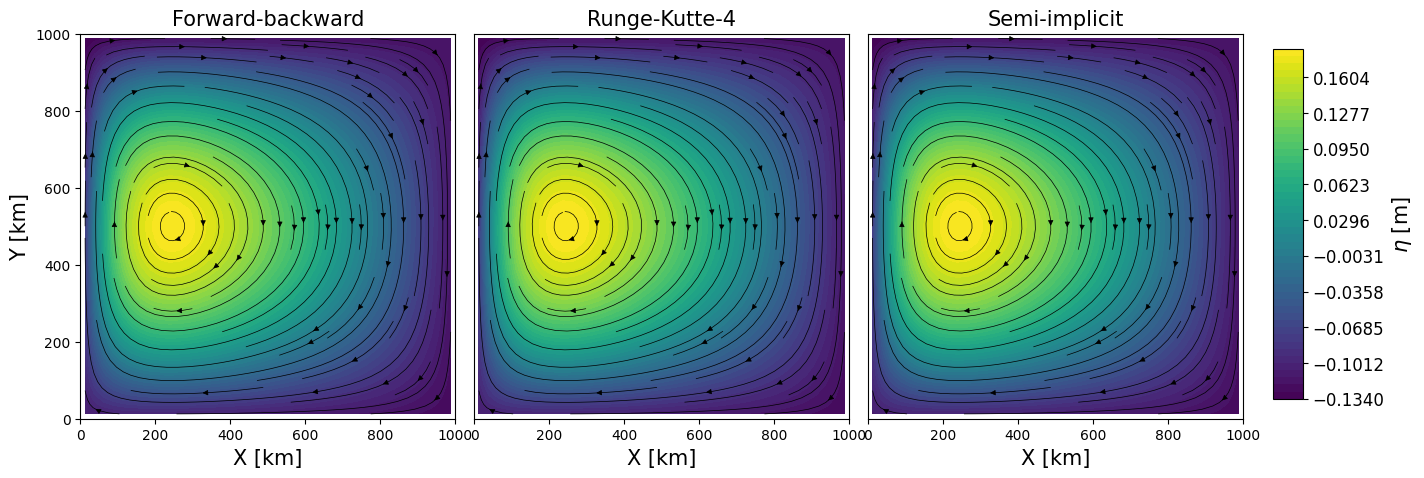

In [13]:
assign2.runTaskG1()

Figure 12: Surface elevation contour plots with overlayed streamlines for each of the numerical solutions. We have disregarded the semi-lagrangian solution, since we are only comparing the linear models here.

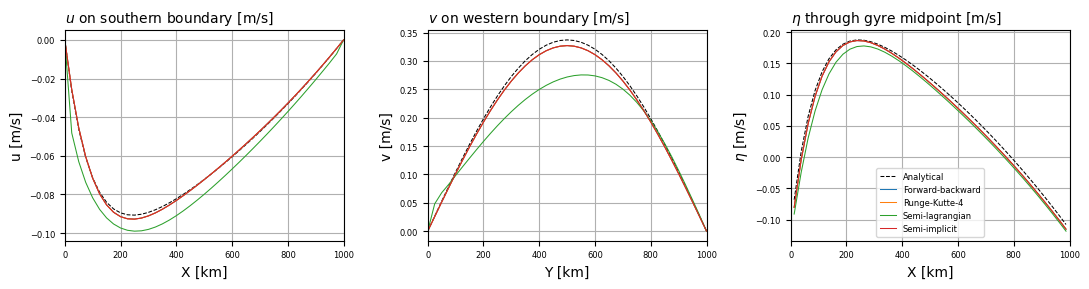

In [14]:
assign2.runTaskG2() # Gyre section comparisons.

Figure 13: Gyre cross sections at the southern boundary, western boundary and midpoint for the different prognostic variables, respectively. All previous time schemes that have been considered here are included, and compared with the analytical solution for the linear model at steady state.

Figure 12 demonstrates consistent agreement among all schemes utilised for the linear model, and minimal discrepancies are observed among the three schemes. We excluded the results of the semi-Lagrangian scheme from this comparison, focusing solely on linear solutions. This consistency persists in Figure 13, where although slight deviations from the analytical solution are apparent, the schemes exhibit remarkable similarity to each other.

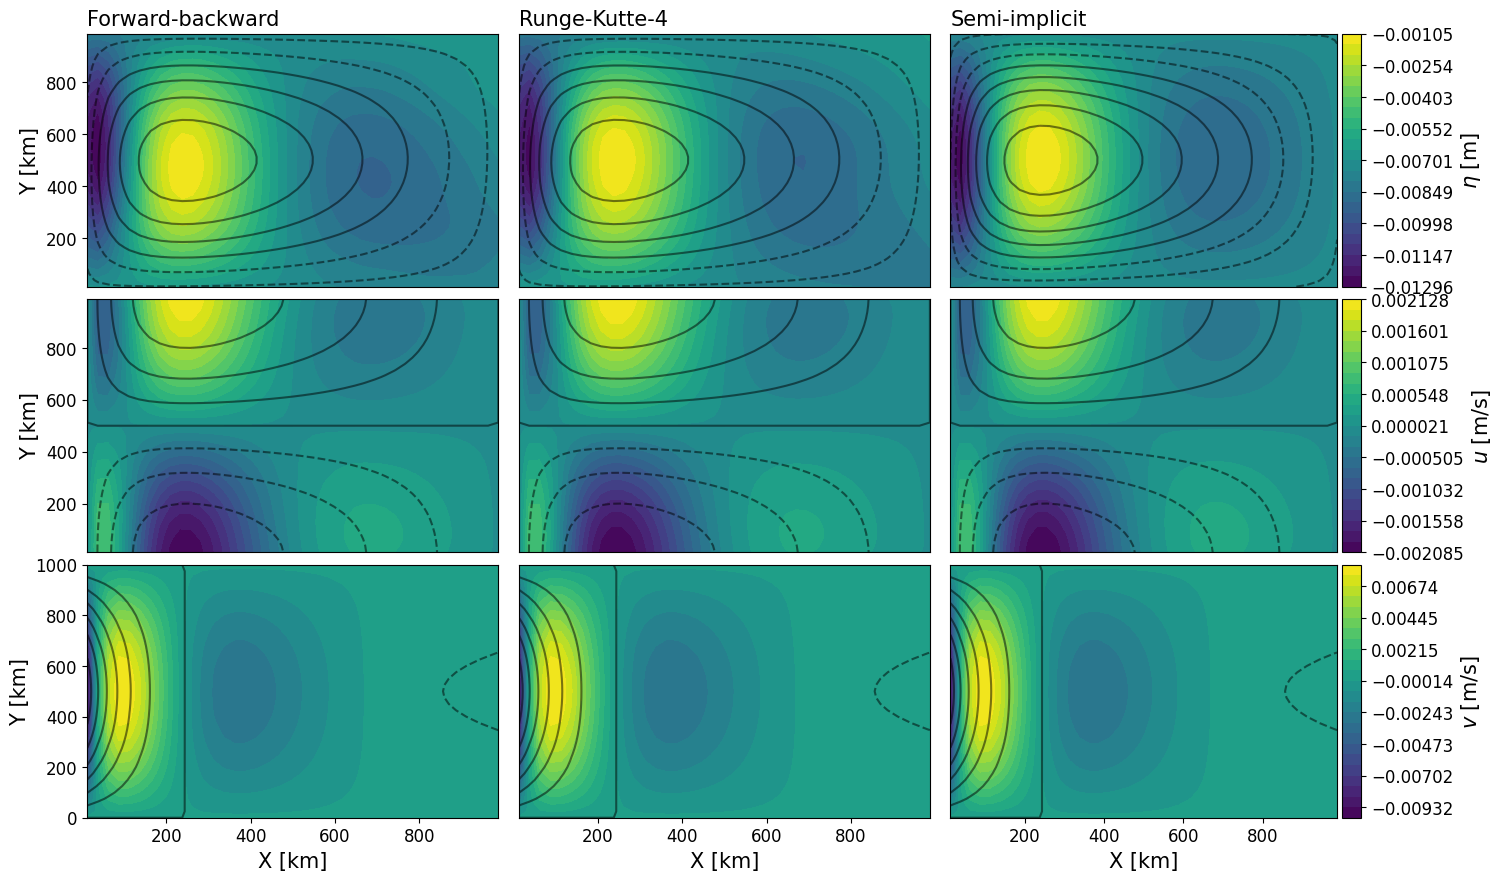

In [15]:
assign2.runTaskG3()

Figure 14: The difference fields between the results of the numerical solutions for the three linear schemes and the analytical solution. The shading denotes the numerical solution, and the black contours are the analytical solutions.

The results of Figure 14 also show minimal differences between the three schemes at this timestep. The main measure of quality for these schemes therefore comes down to computational efficiency. This information is summarised in the table below, alongside their corresponding energy differences. The forward-backwrad scheme stands out as the fastest, followed by the semi-implicit scheme, while the Runge-Kutte scheme begins to incur some computational costs. Although we have refrained from comparing the semi-Lagrangian scheme with the linear models in the previous figures, it is noteworthy that the computational expense associated with this scheme significantly exceeds that of the others considered.

In [16]:
assign2.runTaskGTable()

Scheme,Energy Difference,Time Taken
Forward-backward,3.21e+12J,1.31s
Runge-Kutte-4,3.22e+12J,15.36s
Semi-lagrangian,7.69e+13J,70.00s
Semi-implicit,3.21e+12J,12.28s


#### 8.2 Exploring maximum timesteps

We now explore the maximum timesteps that are achievable with the different numerical schemes. Starting from the CFL criterion, the timestep of each scheme is increased until the solutions are observed to be unstable. The energy difference and the CPU time taken to run the solver is measured for each timestep, and the results are presented in Figure 15.

Max semi-implicit inverse matrix construction time: 0.53125


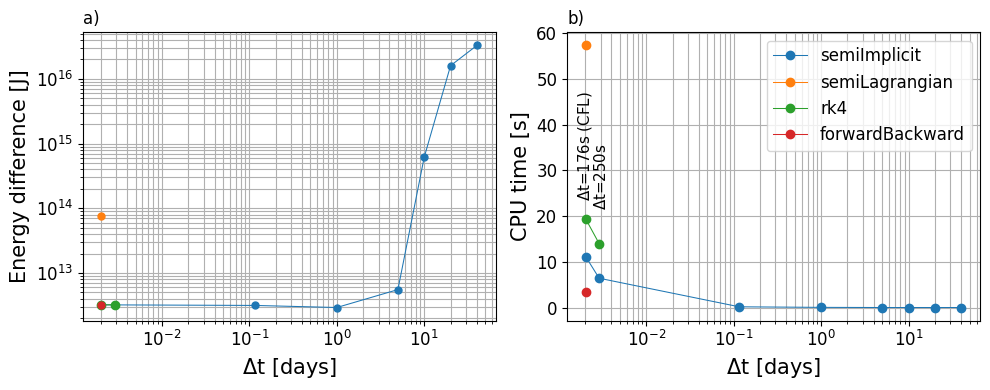

In [2]:
assign2.runTaskG() # Takes a long time to run as well.

Figure 12: The energy difference and the time taken to run the solver for each scheme and for different timesteps. The X axis is log scale for both plots in order to better represent the differences at the smallest timesteps. The energy difference axis is also log scale for the same reason.

It is known that the forward-backward scheme cannot use a larger timestep than $\Delta t=176$s (CFL criterion) for our model parameters. Additionally, due to the simplicity of the semi-Lagrangian scheme that we have implemented, we were also unable to go beyond this timestep, and the scheme is slow with large errors. With the Runge-Kutte scheme, however, we were able to increase the timestep to $\Delta t=250$s. Figure 12 shows that this new timestep is able to speed up the solver runtime by approximately $5$s without any significant loss in accuracy. 

Remarkably, the semi-implicit scheme remained stable across all timesteps considered, and we were able to achieve a timestep of $\Delta t=40$ days corresponding to a single timestep to reach the endtime. Nonetheless, significant energy differences occur at this timestep due to the diffusive properties of the scheme and the large numerical errors from the poor time discretisation. Figure 12 shows no significant error differences compared with the CFL benchmark up until approximately $\Delta t=1$ day, beyond which the errors escalate rapidly. Furthermore, computational overhead for this timestep is small, and is dominated by the time taken to construct the matrix inverse for the implicit terms (typically less than a second in our scenarios). It also appears to be faster than the forward-backward scheme at the CFL limit, which we have used throughout much of this project.

Inverse matrix construction time: 0.828125s
CPU time: 0.03125s


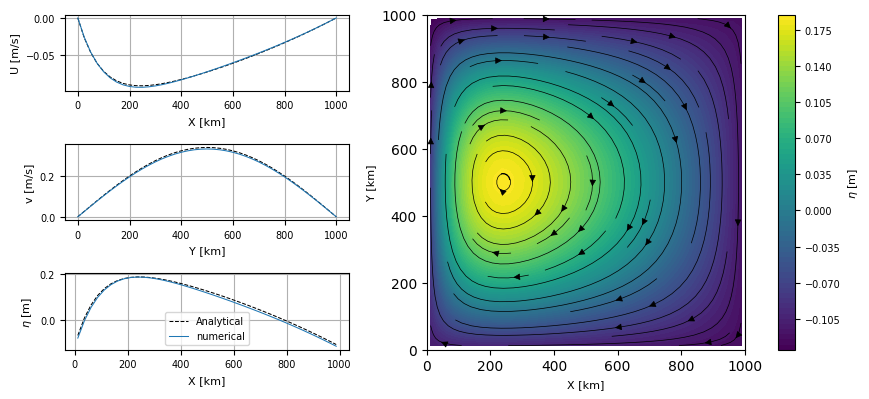

In [3]:
assign2.runTaskG4()

Figure 13: Numerical solutions of the semi-implicit scheme after 40 days for $\Delta t=1$ day. Contents of plots same as in Figure 6.

Figure 13 shows the steady state distribution of the gyre after 40 days using the semi-implicit scheme with a timestep of $\Delta t=1$ day. Remarkably, despite the relatively large timestep, the agreement with the analytical solution is excellent, resembling distributions observed with smaller timesteps. Moreover, the total time to construct the inverse matrix and achieve steady state is under a second. This highlights the semi-implicit scheme as having the most optimal balance between accuracy and computational cost among those considered thus far.

### Discussion

I have checked and this is 6 pages of scientific discussion not including figures, references or appendix.

### References

Matsuno, T. (1966). Numerical simulation of the primitive equations by a simulated backward difference method. J. Meteorol. Soc. Japan, 44, 76–84.

Mushgrave, D. (1985). A numerical study of the roles of subgyre-scale mixing and the western boundary current on homogenisation of a passive tracer. J. Geophys. Res., 90, 7037–7043.

Stommel, H. (1948). The westward intensification of wind-driven ocean currents. Trans. Am. Geophys. Union, 29, 202–206.

Veronis, G. 1966. Wind-driven ocean circulation—Part II. Numerical solution of the nonlinear problem. Deep-Sea Res., 13, 30–55.


### Appendix (not included as part of my 6 pages please)

### A. Numerical schemes

Definitions and details of the numerical schemes can be found in the lecture notes. Schemes where special considerations had to be taken are considered here.

#### A.1 Semi-Lagrangian

Sufficient details of the semi-lagrangian scheme are found in the notes so will not be repeated here. The departure point calculation is done using a two-stage mid-point method, andto compute the velocity at the mid-point, we calculate:

\begin{align}
u\left(t_{n+\frac{1}{2}}\right) = \frac{3}{2} u\left(t_n\right) - \frac{1}{2} u\left(t_{n-1}\right)
\end{align}

The advection equation is then solved using a trapezoidal scheme.

#### A.2 Semi-implicit

In the semi-implicit scheme we use a forward difference scheme for the temporal and spatial discretisation of the explicit terms, and treat the gravity terms implicitly. The discretised equations are summarised below.

\begin{align}
u^{n+1} + g\Delta t \frac{\partial \eta^{n+1}}{\partial x} &= u^n + \Delta t \left( fv^n - \gamma u^n + \frac{\tau_x}{\rho H} \right) \\
&= A
\end{align}

\begin{align}
v^{n+1} + g\Delta t \frac{\partial \eta^{n+1}}{\partial y} &= v^n + \Delta t \left( - fu^n - \gamma v^n + \frac{\tau_y}{\rho H} \right) \\
&= B
\end{align}

\begin{align}
\eta^{n+1} + H\Delta t \left( \frac{\partial u^{n+1}}{\partial x} + \frac{\partial v^{n+1}}{\partial y} \right) &= \eta^n \\
&= C
\end{align}

Equations 10 and 11 can be substituted into Equation 12 to form the following.

\begin{align}
\eta^{n+1} - gH\Delta t^2 \left(\frac{\partial^2 \eta^{n+1}}{\partial x^2} + \frac{\partial^2 \eta^{n+1}}{\partial y^2}\right) = C - \Delta tH \left(\frac{\partial A}{\partial x} + \frac{\partial B}{\partial y}\right) \\ 
&= F
\end{align}

From this we can form the following matrix equation, 

\begin{align}
\ell \eta^{n+1} = F
\end{align}

where, 
\begin{align}
\ell = \{ 1 - gH\Delta t^2 \left(\frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}\right) \}
\end{align}

This equation can then be inverted to obtain $\eta^{n+1}$, and this can be plugged into the expression for the $u^{n+1}$ and $v^{n+1}$ to obtain the updated velocity fields. The matrix inversion is done once when the scheme is initialised.

In A and B, the boundary conditions are dealt with the same way as usual for the velocity fields - since normal flow at the boundaries is zero, we only update the internal points. For the matrix $\ell$, we must incorporate the zero $\eta$ flux boundary conditions.